In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import os
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [2]:
# Plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [3]:
# Load the data
# def load_data(file_path):
#     with open(file_path, 'r') as f:
#         data = json.load(f)
#     return pd.DataFrame(data)

# Path to the JSON data
def load_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return pd.DataFrame(data)
    except UnicodeDecodeError:
        # If utf-8 fails, try with error handling
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            data = json.load(f)
        return pd.DataFrame(data)
    except Exception as e:
        # Last resort: binary read
        with open(file_path, 'rb') as f:
            raw_data = f.read()
        # Replace problematic characters
        cleaned_data = raw_data.decode('utf-8', errors='replace')
        data = json.loads(cleaned_data)
        return pd.DataFrame(data)
    
json_file_path = '../data/raw/hub_notifications.json'  # Update with your actual filename
df = load_data(json_file_path)

### Basic Information

In [4]:
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

Dataset Shape: (108, 18)

Data Types:
id                object
title             object
description       object
type              object
classification    object
tile              object
role              object
start              int64
end                int64
created_date       int64
updated_date       int64
created_by        object
_rid              object
_self             object
_etag             object
_attachments      object
_ts                int64
updated_by        object
dtype: object


### Check for null values

In [5]:
null_counts = df.isnull().sum()
print("\nNull Value Counts:")
print(null_counts)
print("\nPercentage of Null Values:")
print(100 * null_counts / len(df))


Null Value Counts:
id                  0
title               0
description         0
type              104
classification    104
tile                0
role                0
start               0
end                 0
created_date        0
updated_date        0
created_by          3
_rid                0
_self               0
_etag               0
_attachments        0
_ts                 0
updated_by          6
dtype: int64

Percentage of Null Values:
id                 0.000000
title              0.000000
description        0.000000
type              96.296296
classification    96.296296
tile               0.000000
role               0.000000
start              0.000000
end                0.000000
created_date       0.000000
updated_date       0.000000
created_by         2.777778
_rid               0.000000
_self              0.000000
_etag              0.000000
_attachments       0.000000
_ts                0.000000
updated_by         5.555556
dtype: float64


### Notifications sent by month

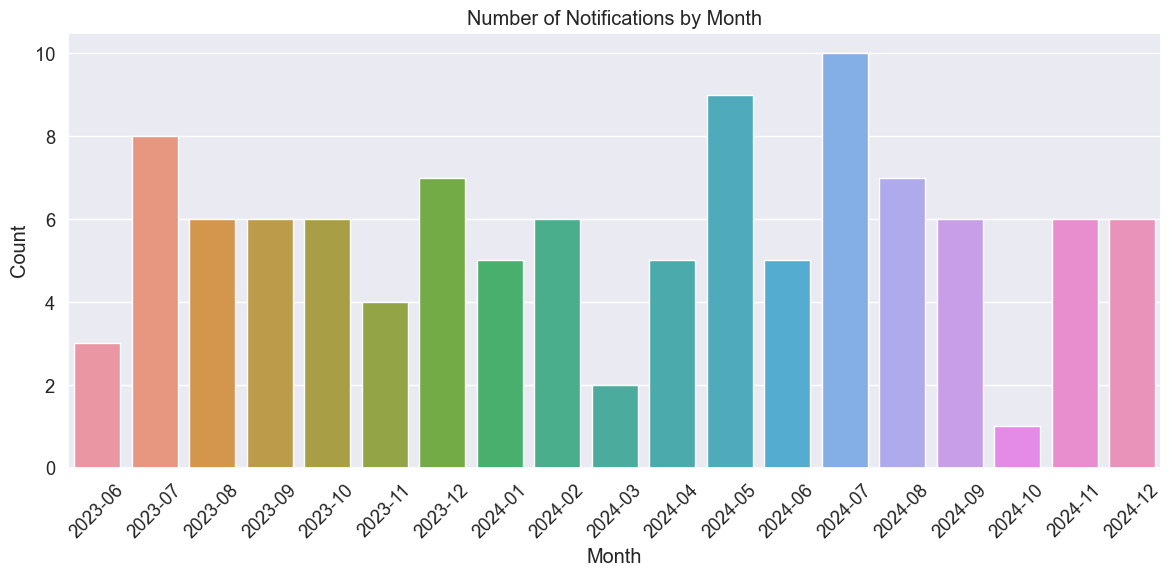

In [6]:
# Convert timestamp columns to datetime
time_columns = ['start', 'end', 'created_date', 'updated_date', '_ts']
for col in time_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], unit='ms')
        
# Extract month and year for time-based analysis
df['created_month'] = df['created_date'].dt.month
df['created_year'] = df['created_date'].dt.year
df['created_month_year'] = df['created_date'].dt.strftime('%Y-%m')
df['created_day_of_week'] = df['created_date'].dt.dayofweek
df['created_hour'] = df['created_date'].dt.hour

# Calculate notification duration in days
df['duration_days'] = (df['end'] - df['start']).dt.total_seconds() / (24 * 60 * 60)

# Text features
df['title_length'] = df['title'].str.len()
df['description_length'] = df['description'].str.len()
df['has_type'] = df['type'].notnull().astype(int)
df['has_classification'] = df['classification'].notnull().astype(int)

# List features
df['tile_count'] = df['tile'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['role_count'] = df['role'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Time between creation and update
df['update_delay_hours'] = (df['updated_date'] - df['created_date']).dt.total_seconds() / 3600

# Analyze notifications by month
monthly_counts = df.groupby('created_month_year').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='created_month_year', y='count', data=monthly_counts)
plt.title('Number of Notifications by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

### Notifications sent by day of week

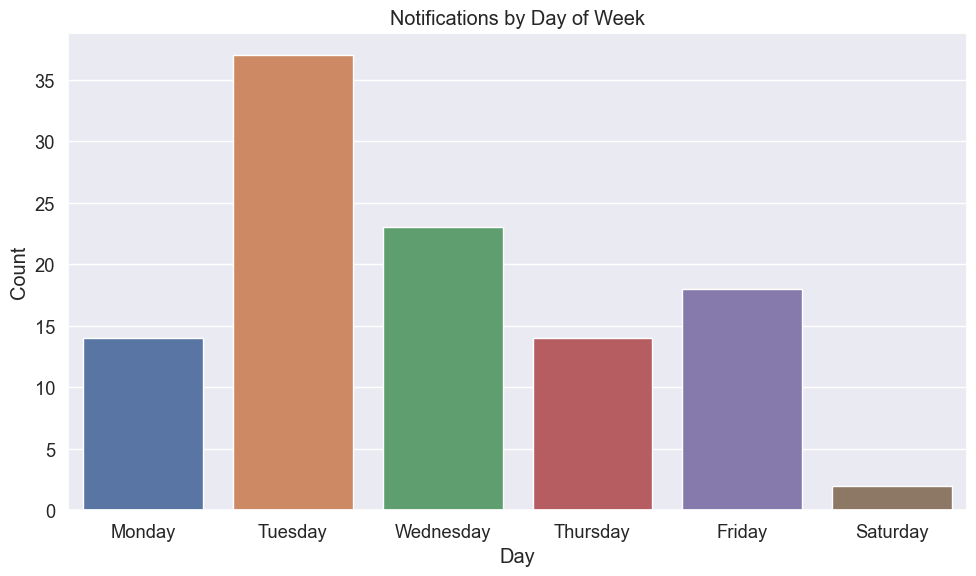

In [7]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df.groupby('created_day_of_week').size().reset_index(name='count')
day_counts['day_name'] = day_counts['created_day_of_week'].apply(lambda x: day_names[x])

plt.figure(figsize=(10, 6))
sns.barplot(x='day_name', y='count', data=day_counts)
plt.title('Notifications by Day of Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.tight_layout()

### Top 10 tiles by sent notification count

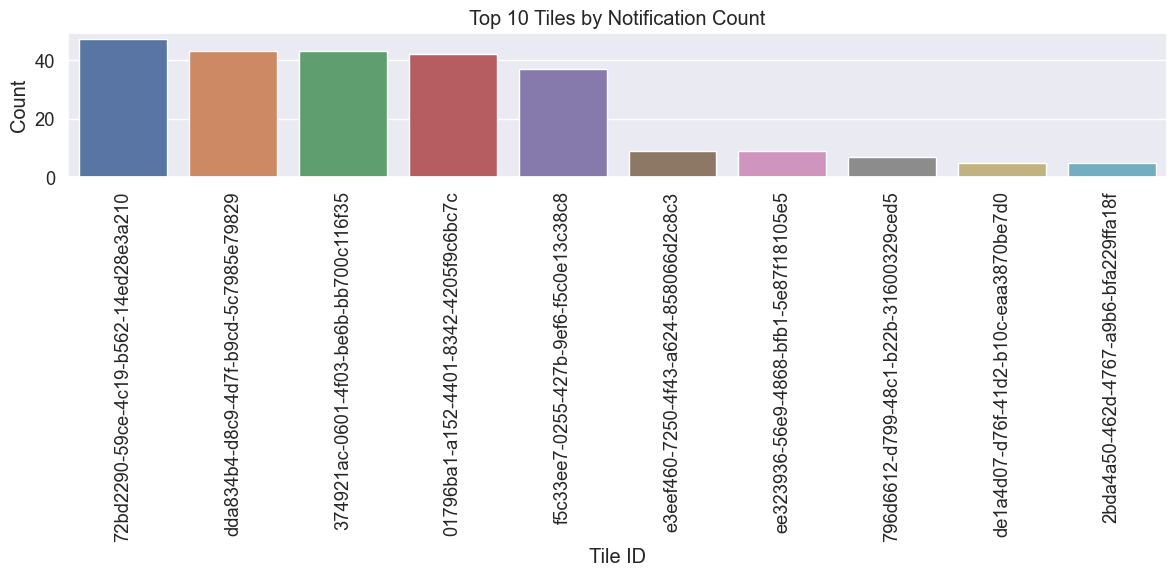

In [8]:
# Exploding tile column
tile_df = df.explode('tile')
tile_counts = tile_df['tile'].value_counts().reset_index()
tile_counts.columns = ['tile', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(x='tile', y='count', data=tile_counts.head(10))
plt.title('Top 10 Tiles by Notification Count')
plt.xlabel('Tile ID')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

### Correlation matrix for numerical features

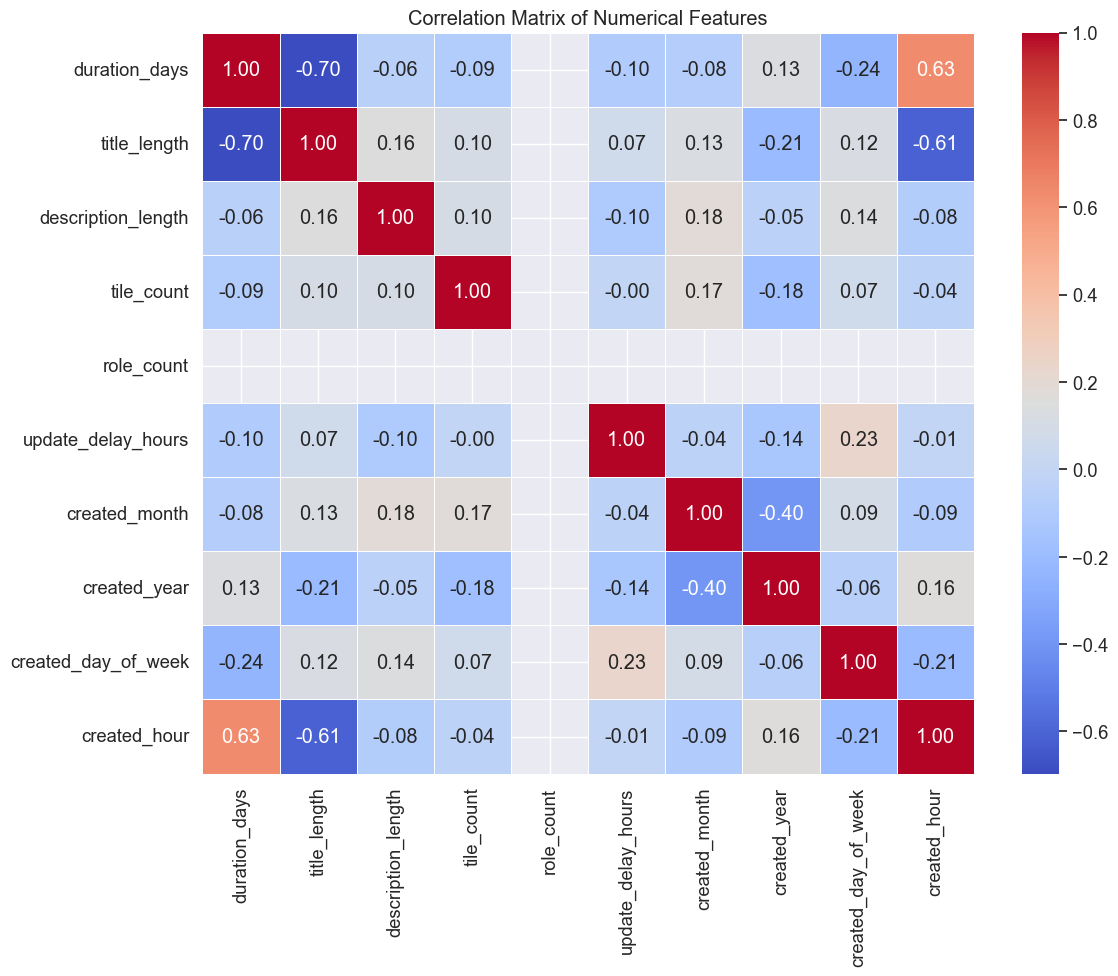

In [9]:
numeric_cols = ['duration_days', 'title_length', 'description_length',
                'tile_count', 'role_count', 'update_delay_hours',
                'created_month', 'created_year', 'created_day_of_week', 'created_hour']
numeric_df = df[numeric_cols].copy()

# Fill NaN values with median for correlation analysis
for col in numeric_df.columns:
    numeric_df[col] = numeric_df[col].fillna(numeric_df[col].median())

# Correlation matrix
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()

### Top notification creators

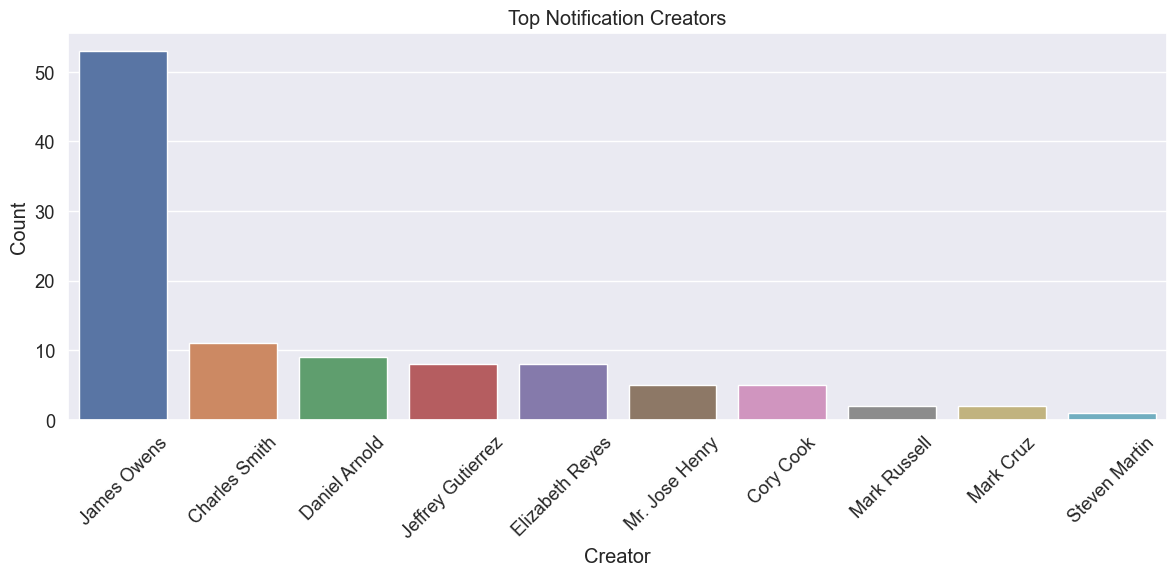

In [10]:
# Analyze creators
creator_counts = df['created_by'].value_counts().reset_index()
creator_counts.columns = ['created_by', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(x='created_by', y='count', data=creator_counts.head(10))
plt.title('Top Notification Creators')
plt.xlabel('Creator')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

### Null values by column

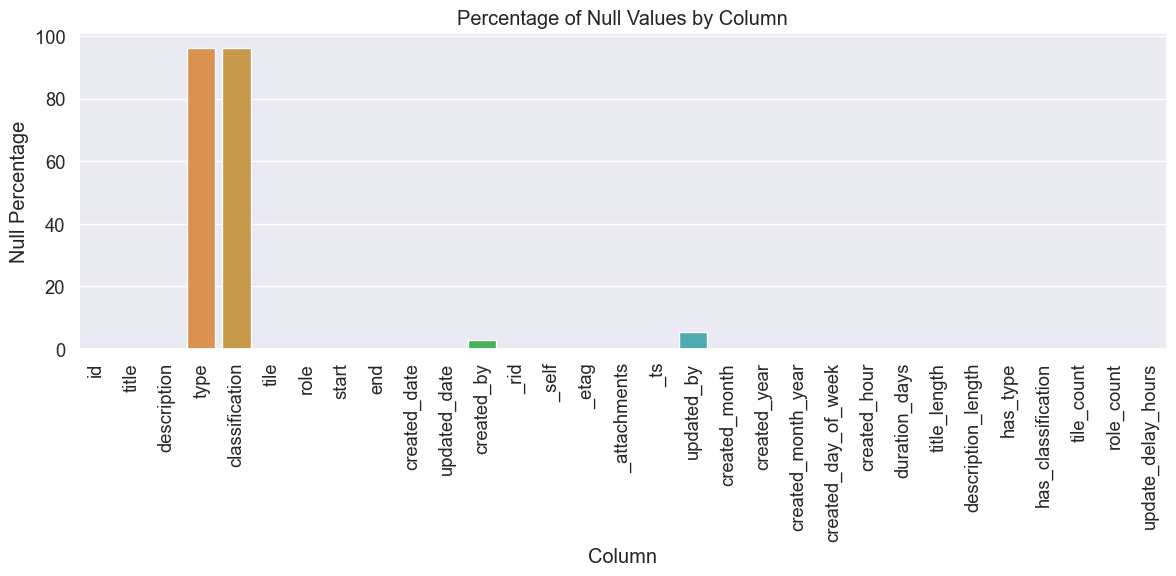

In [11]:
# Analyze null values by column
null_df = pd.DataFrame({
    'column': df.columns,
    'null_count': df.isnull().sum().values,
    'null_percentage': 100 * df.isnull().sum().values / len(df)
})

plt.figure(figsize=(12, 6))
sns.barplot(x='column', y='null_percentage', data=null_df)
plt.title('Percentage of Null Values by Column')
plt.xlabel('Column')
plt.ylabel('Null Percentage')
plt.xticks(rotation=90)
plt.tight_layout()

### Notifications over time

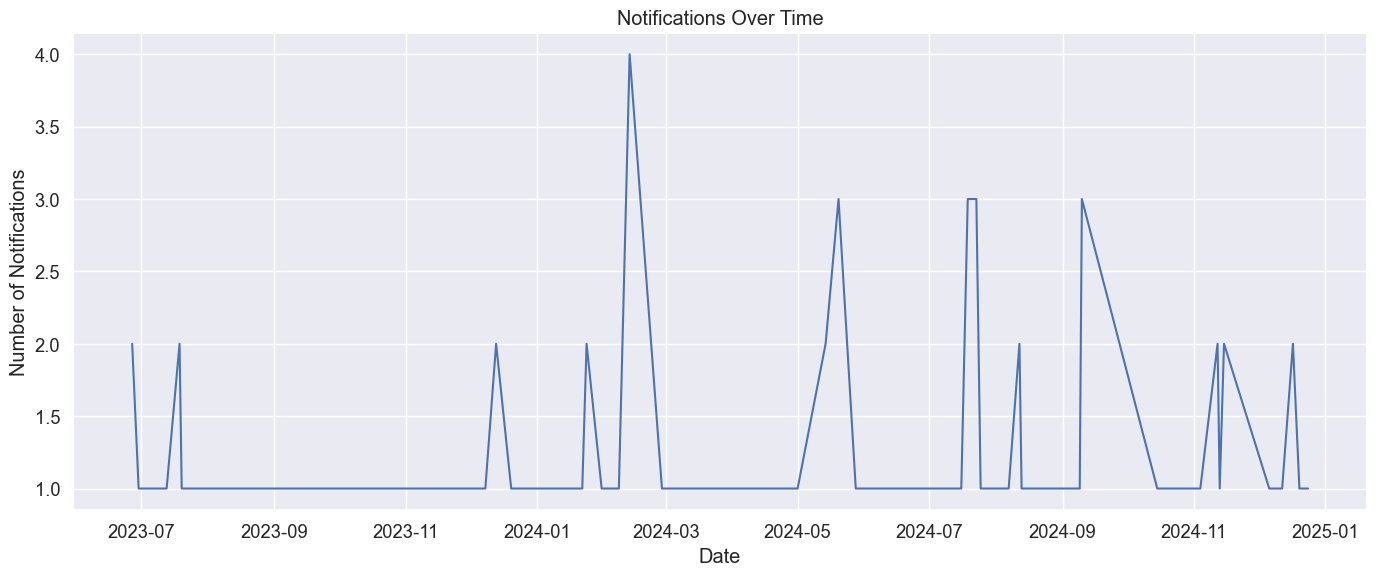

In [12]:
# Time series analysis
df['date'] = df['created_date'].dt.date
daily_counts = df.groupby('date').size().reset_index(name='count')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

plt.figure(figsize=(14, 6))
plt.plot(daily_counts['date'], daily_counts['count'])
plt.title('Notifications Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Notifications')
plt.grid(True)
plt.tight_layout()

### Distribution of notification duration

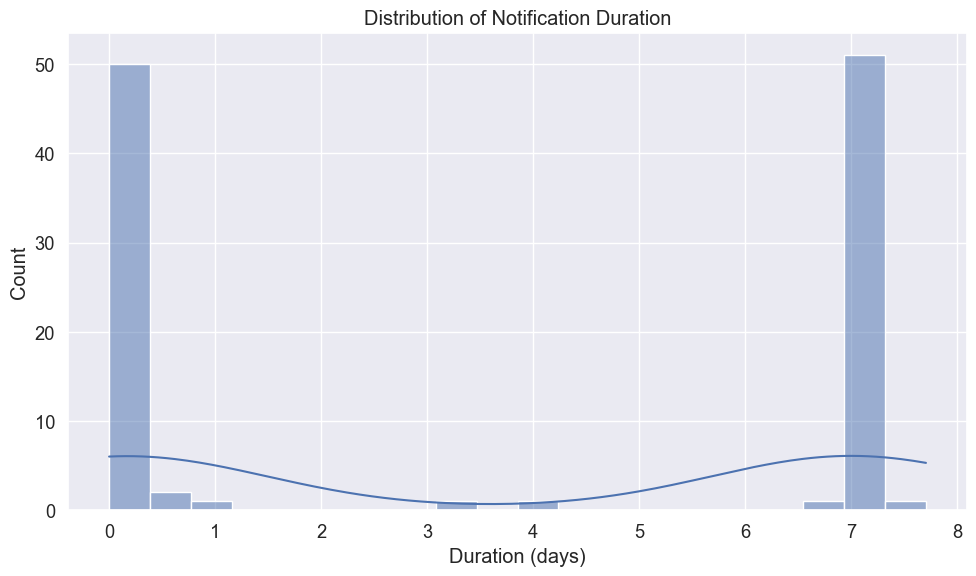

In [13]:
# Analyze notification duration
plt.figure(figsize=(10, 6))
sns.histplot(df['duration_days'].dropna(), bins=20, kde=True)
plt.title('Distribution of Notification Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Count')
plt.tight_layout()

In [17]:
### Major and Minor Notification Analysis

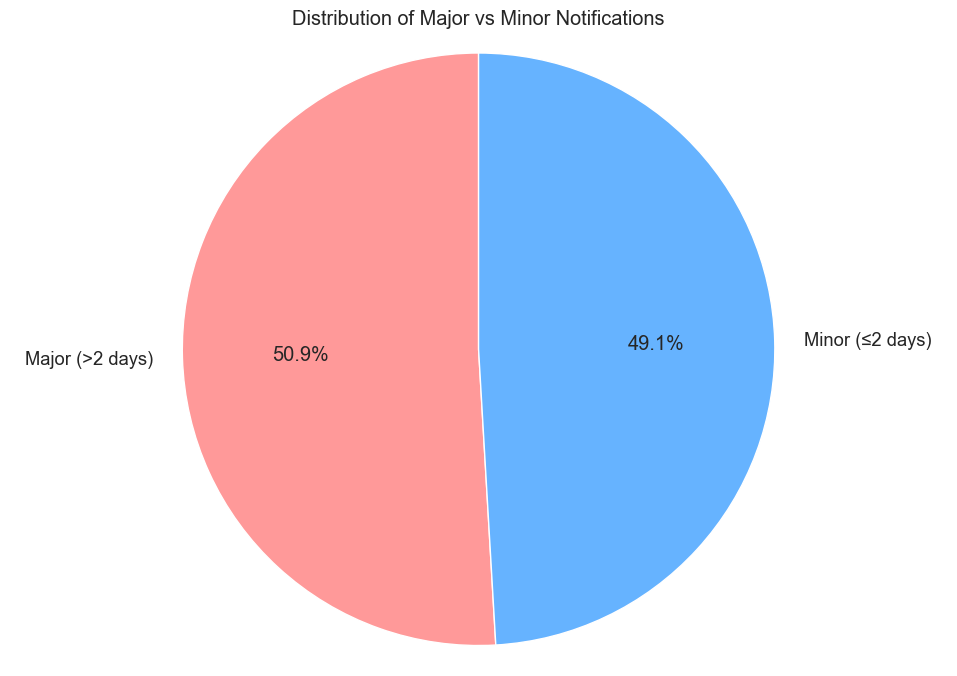

In [18]:
# Create a classification for major vs minor notifications based on duration
# Major: duration > 2 days
# Minor: duration ≤ 2 days

# Add a column to classify notifications
df['is_major'] = df['duration_days'] > 2

# Count major vs minor notifications
major_minor_counts = df['is_major'].value_counts().reset_index()
major_minor_counts.columns = ['is_major', 'count']
major_minor_counts['notification_type'] = major_minor_counts['is_major'].map({True: 'Major (>2 days)', False: 'Minor (≤2 days)'})

# Create a pie chart
plt.figure(figsize=(10, 7))
plt.pie(major_minor_counts['count'], labels=major_minor_counts['notification_type'],
        autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Major vs Minor Notifications')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()

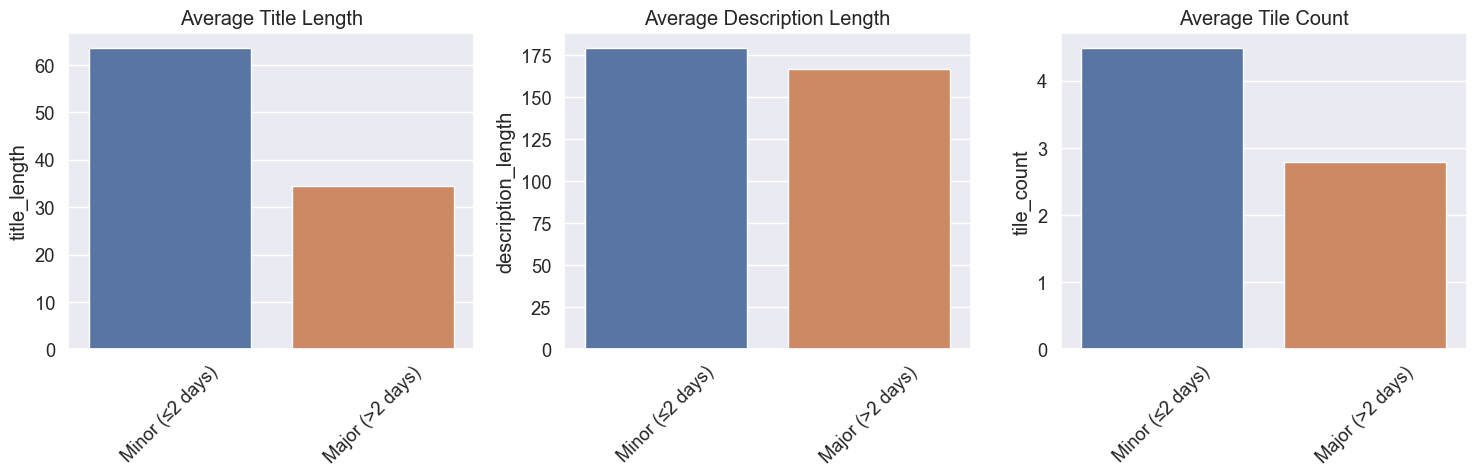

In [19]:
# Create a bar chart comparing characteristics of major vs minor notifications
characteristics = ['title_length', 'description_length', 'tile_count']
major_minor_stats = df.groupby('is_major')[characteristics].mean().reset_index()
major_minor_stats['notification_type'] = major_minor_stats['is_major'].map({True: 'Major (>2 days)', False: 'Minor (≤2 days)'})

# Create a multi-bar chart
plt.figure(figsize=(15, 5))
for i, characteristic in enumerate(characteristics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='notification_type', y=characteristic, data=major_minor_stats)
    plt.title(f'Average {characteristic.replace("_", " ").title()}')
    plt.xlabel('')
    plt.xticks(rotation=45)
plt.tight_layout()

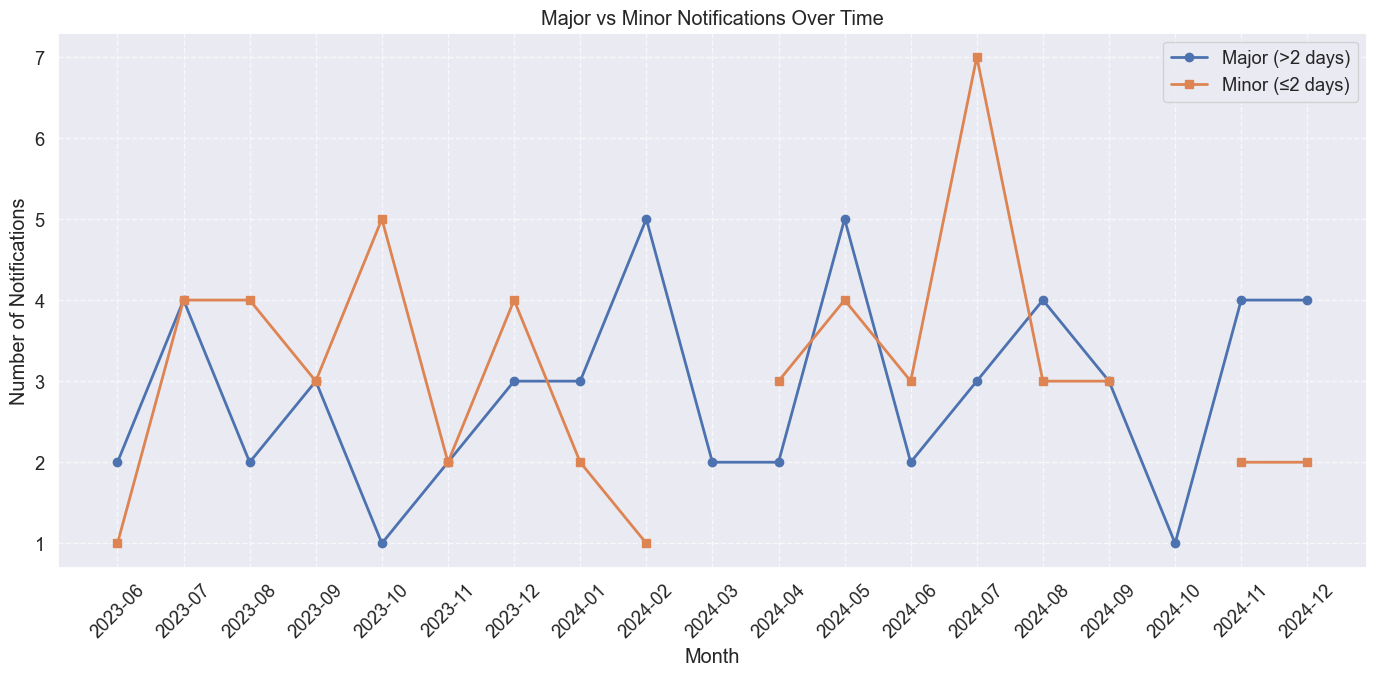

In [20]:
# Time series of major vs minor notifications
df['month_year'] = df['created_date'].dt.to_period('M')
monthly_major_minor = df.groupby(['month_year', 'is_major']).size().unstack().reset_index()
monthly_major_minor['month_year'] = monthly_major_minor['month_year'].astype(str)

# Rename columns for clarity
if True in monthly_major_minor.columns and False in monthly_major_minor.columns:
    monthly_major_minor.rename(columns={True: 'Major (>2 days)', False: 'Minor (≤2 days)'}, inplace=True)

# Plot time series
plt.figure(figsize=(14, 7))
if 'Major (>2 days)' in monthly_major_minor.columns:
    plt.plot(monthly_major_minor['month_year'], monthly_major_minor['Major (>2 days)'],
             marker='o', linewidth=2, label='Major (>2 days)')
if 'Minor (≤2 days)' in monthly_major_minor.columns:
    plt.plot(monthly_major_minor['month_year'], monthly_major_minor['Minor (≤2 days)'],
             marker='s', linewidth=2, label='Minor (≤2 days)')
plt.title('Major vs Minor Notifications Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Notifications')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

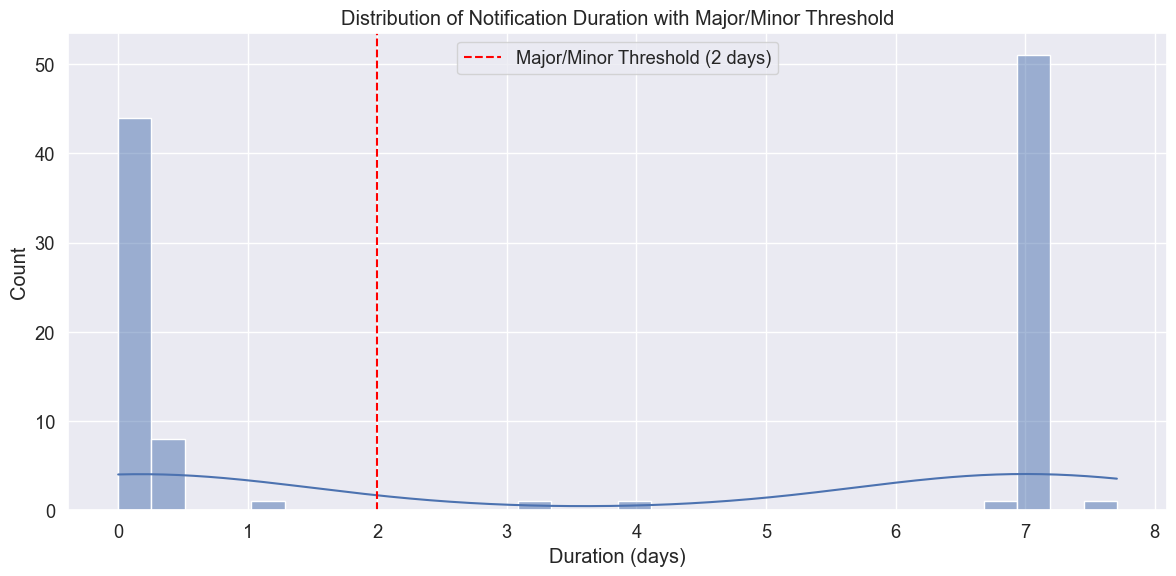

In [21]:
# Create a histogram of durations with a vertical line at the threshold
plt.figure(figsize=(12, 6))
sns.histplot(df['duration_days'].dropna(), bins=30, kde=True)
plt.axvline(x=2, color='red', linestyle='--', label='Major/Minor Threshold (2 days)')
plt.title('Distribution of Notification Duration with Major/Minor Threshold')
plt.xlabel('Duration (days)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

In [22]:
# Print summary statistics
print("\nMajor vs Minor Notification Statistics:")
print(f"Major notifications (>2 days): {df['is_major'].sum()} ({df['is_major'].mean()*100:.1f}%)")
print(f"Minor notifications (≤2 days): {(~df['is_major']).sum()} ({(~df['is_major']).mean()*100:.1f}%)")

# Additional analysis: Compare tile distribution between major and minor
major_tiles = df[df['is_major']].explode('tile')['tile'].value_counts().head(5)
minor_tiles = df[~df['is_major']].explode('tile')['tile'].value_counts().head(5)

print("\nTop 5 Tiles in Major Notifications:")
print(major_tiles)

print("\nTop 5 Tiles in Minor Notifications:")
print(minor_tiles)


Major vs Minor Notification Statistics:
Major notifications (>2 days): 55 (50.9%)
Minor notifications (≤2 days): 53 (49.1%)

Top 5 Tiles in Major Notifications:
796d6612-d799-48c1-b22b-31600329ced5    5
8dd7c7ca-fcc9-43d8-9ab2-e1c8ce470714    4
46f54c6e-3a9b-4208-a4c7-1bec297d7f61    3
2bda4a50-462d-4767-a9b6-bfa229ffa18f    3
70c71721-2e5f-489c-9c50-143f4e08a5be    3
Name: tile, dtype: int64

Top 5 Tiles in Minor Notifications:
72bd2290-59ce-4c19-b562-14ed28e3a210    46
374921ac-0601-4f03-be6b-bb700c116f35    42
01796ba1-a152-4401-8342-4205f9c6bc7c    41
dda834b4-d8c9-4d7f-b9cd-5c7985e79829    41
f5c33ee7-0255-427b-9ef6-f5c0e13c38c8    34
Name: tile, dtype: int64
